# Traffic Signs Classifier

We built a traffic signs classifier using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=news), deep learning and TensorFlow. 

A 98.9% accuracy has been obtained on the test set which is higher than that of humans (98.83%) thanks to ideas from [sermanet-ijcnn-11](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

# Problem

* Image ≡ (32,32,3) tensor of uint8 representing German traffic signs.
* Label ≡ [0-42] representing a type of sign.
* Each image has one label : Image × Label
* Implement `f : Image → Label`

# Context

In [1]:
import matplotlib
matplotlib.rcParams['font.size'] = 10
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage import transform as tr
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from scipy import misc
from sklearn.utils import shuffle
from skimage.util import random_noise
from skimage.color import rgb2gray
from skimage import exposure
from lib import images_distribution
from lib import plot_barchart_of_distribution
from lib import graph_images
from lib import draw_random_images
from lib import get_data
from lib import split_data
from lib import extend_images_labels
from lib import preprocess_images
from lib import collect_results
from lib import to_accuracy_precision_recall
from lib import to_true_false_positive_negative
from lib import collect_results
from lib import model_accuracy
from lib import get_and_split_web_traffic_signs
from lib import predict
from lib import graph_image_prob
from lib import accuracy
from lib import show_hidden_layers

# Load Training, Validation And Test Data

# Data

Import data: `X ≡ [image, …], Y ≡ [label, …]` such that `zip(X,Y) ≡ [(image, label), …]`:

In [2]:
X,Y = get_data()

Split data into training, validation and test sets:

In [3]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data(X,Y)

## Analysis

### Images' Shape

In [4]:
print("Image data shape =", X_train[0].shape)

Image data shape = (32, 32, 3)


### Distribution Of Images By Sets

In [5]:
total = len(X_train)+len(X_valid)+len(X_test)
print("Total number of examples: ",total)
print("Number of classes =", len(set(Y_train)))
print("")
print("Number of training examples =", len(X_train))
print("Number of validation examples =", len(X_valid))
print("Number of testing examples =", len(X_test))
print("")
print("training/total = {:.1%}".format(len(X_train)/total))
print("validation/total = {:.1%}".format(len(X_valid)/total))
print("test/total = {:.1%}".format(len(X_test)/total))

Total number of examples:  51839
Number of classes = 43

Number of training examples = 36287
Number of validation examples = 10419
Number of testing examples = 5133

training/total = 70.0%
validation/total = 20.1%
test/total = 9.9%


### Distribution Of Images By Labels

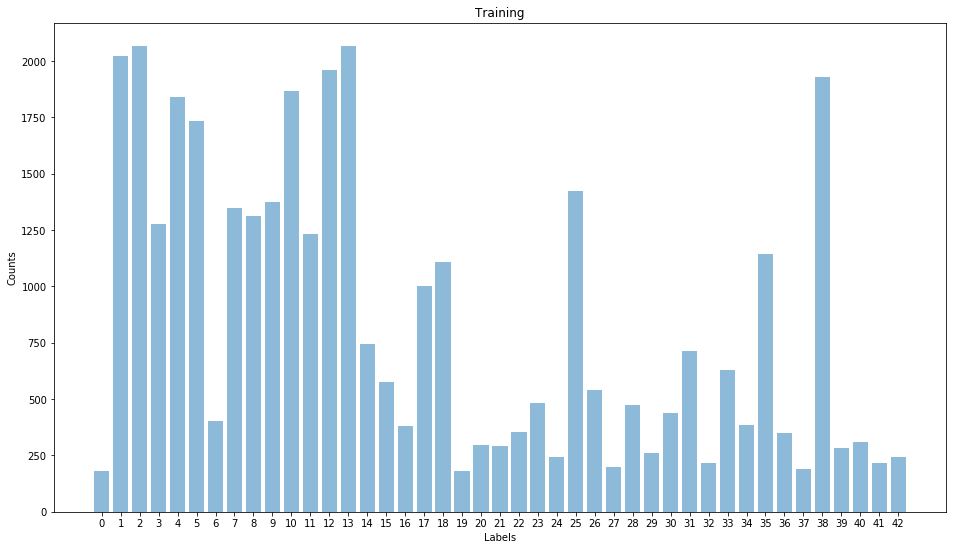

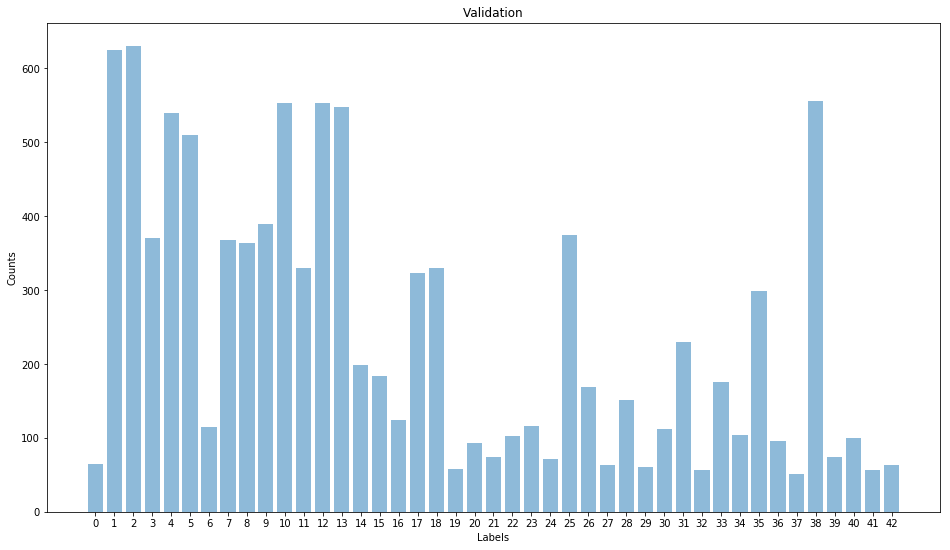

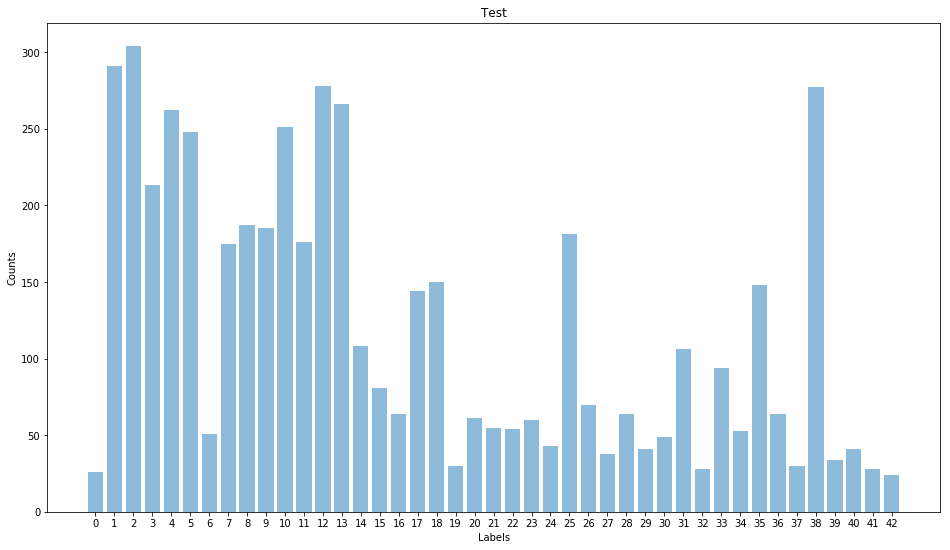

In [6]:
plot_barchart_of_distribution(images_distribution(Y_train), title="Training",x_label="Labels",y_label="Counts")
plot_barchart_of_distribution(images_distribution(Y_valid), title="Validation",x_label="Labels",y_label="Counts")
plot_barchart_of_distribution(images_distribution(Y_test), title="Test",x_label="Labels",y_label="Counts")

### Visualisation

Display random images:

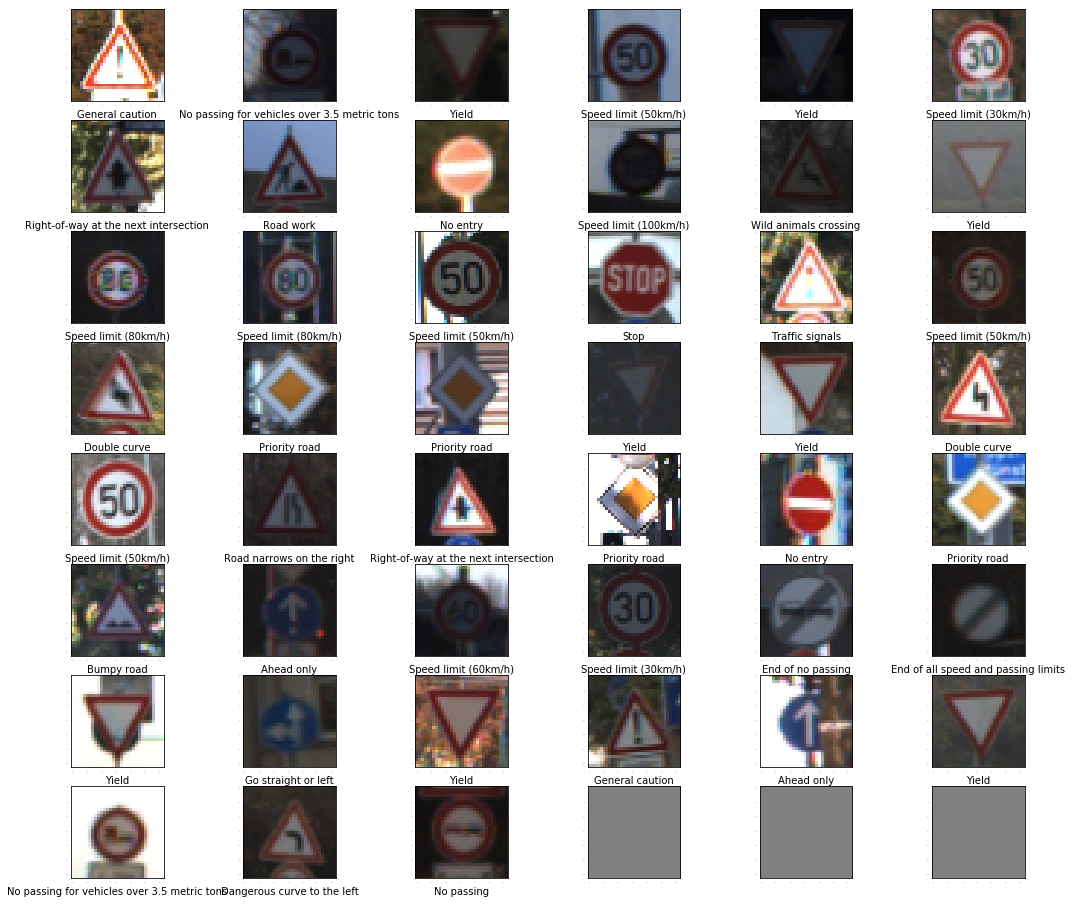

In [7]:
rand_images, rand_labels, random_indexes = draw_random_images(X_train,Y_train,45)         
graph_images(rand_images,rand_labels)

Display images of a given label:

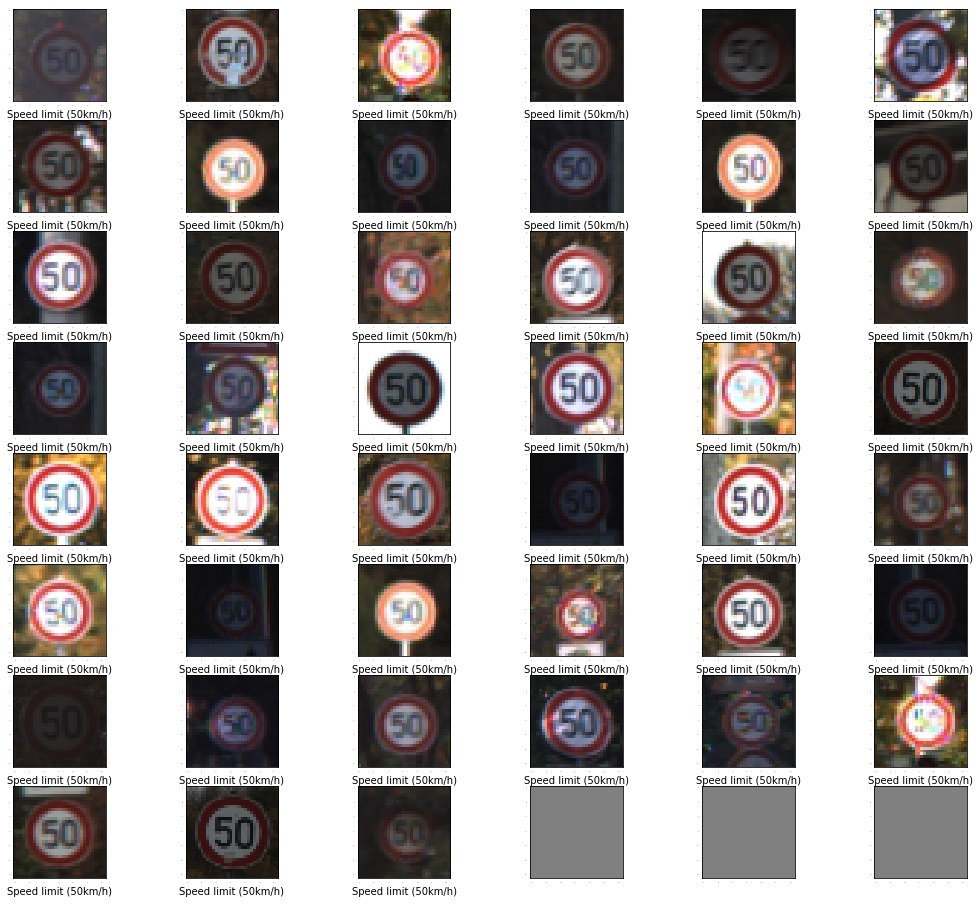

In [8]:
rand_images, rand_labels, random_indexes = draw_random_images(X_train,Y_train,45,select=2)         
graph_images(rand_images,rand_labels)

## Synthesis

* Distribution Of Images By Labels: uneven.
* Visualisation: contrast is uneven. Images with a given label are very similar in term of centering, rough proportion of pixels occupied by the signs wrt background, signs orientation. Signs can be very different in terms of contrast, blur and noise (e.g. damaged signs vs pristine ones). 

## Conclusion

* Test with/without colors: are colors necessary?
* Test with/without contrast: is it necessary that the network learns ≠ contrasts?
* Test with/without distribution of images per labels correction: uneven training makes an unevenly trained network and there is no reason for expecting more signs than others. Correct by creating examples from existing examples and transformations and noise.
* Normalise pixel values because mean ≠ 0.

# Preprocessing

## Make Data Distribution Even Across Classes

Experimenting to find sensible random parameters ranges. The idea is to find ranges of parameters to mimic variability of the data set to complete it with generated images. Too much variation and the data set is destroyed, not enough and they put the data set at risk for some bias.

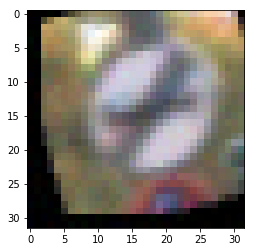

In [9]:
test_image = X[100]
r_img = tr.rotate(test_image,15.)                                 # [-15., +15.]
tr_r_img = tr.warp(r_img, tr.AffineTransform(translation=(-2,2))) # [-2,+2]
noised_tr_r_img = random_noise(tr_r_img,var=0.00025)              # [0, 0.00025]
plt.imshow(noised_tr_r_img)

For each class of images, complete it with variations of existing images using above parameters.  Without this modification, the training data set would be uneven which implies that the training would be uneven which is not what we want since we need the classifier to perform equally well across the classes.

In [10]:
X_extended, Y_extended = extend_images_labels(X,Y)

Check that the distribution of images by class is now even:

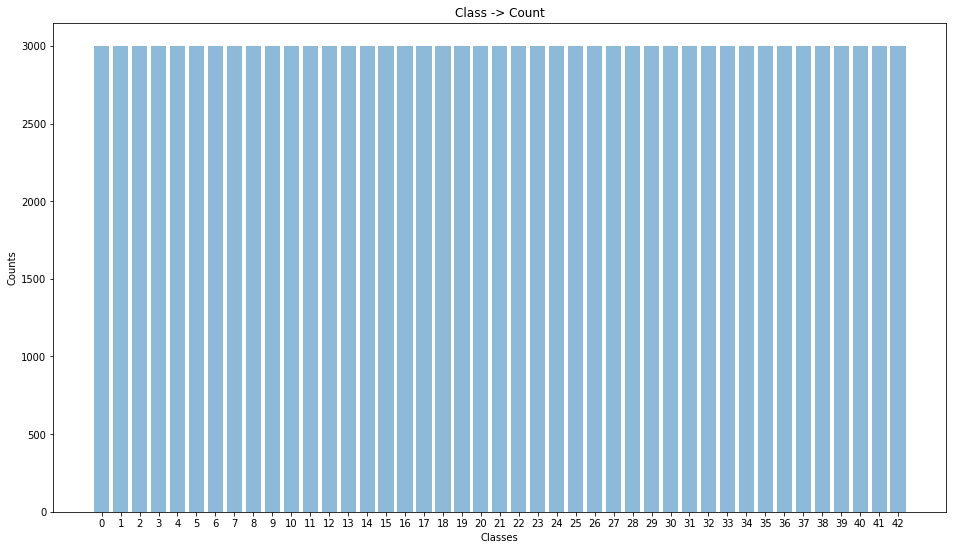

In [11]:
plot_barchart_of_distribution(images_distribution(Y_extended), 
                              title="Class -> Count",
                              x_label="Classes",
                              y_label="Counts")

Do we really need colors to classify traffic signs? If we get rid of the colors then we have 3 times less data to take care of and there is a good chance that colors are not that much necessary:

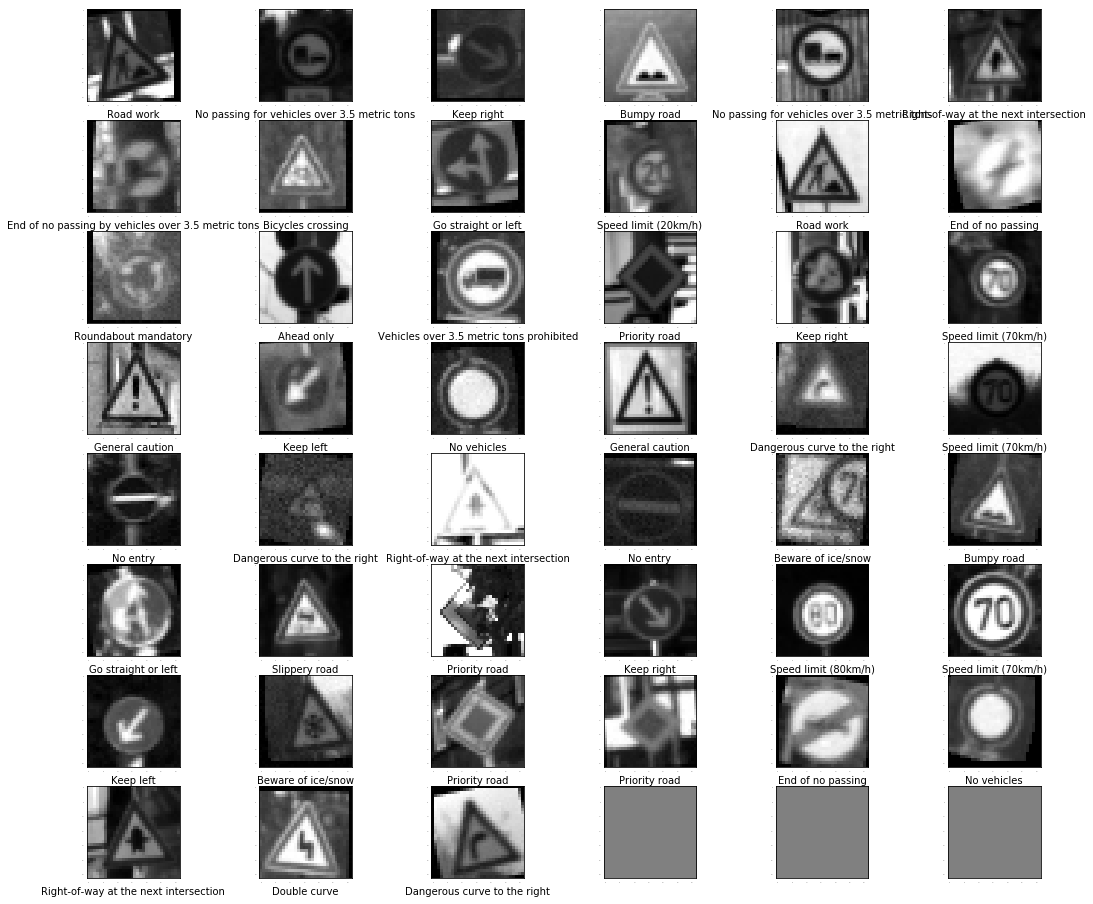

In [12]:
X_extended_gray = np.array([rgb2gray(image) for image in X_extended])
rand_images, rand_labels, random_indexes = draw_random_images(X_extended_gray,Y_extended,45)         
graph_images(rand_images,rand_labels)

Variation of contrasts can be normalized so that the learning can focus on other kind of differences to classify the signs:

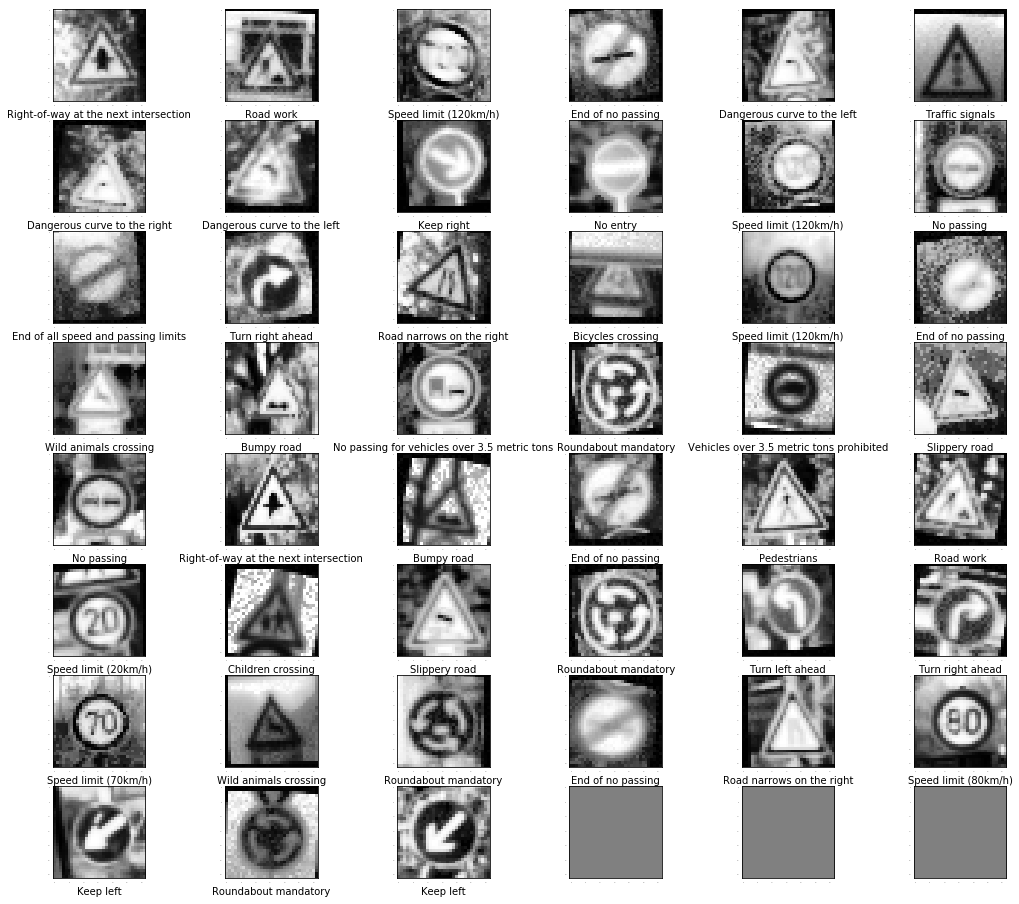

In [13]:
X_extended_gray_contrast = np.array([exposure.equalize_hist(image) for image in X_extended_gray])
rand_images, rand_labels, random_indexes = draw_random_images(X_extended_gray_contrast,Y_extended,45)         
graph_images(rand_images,rand_labels)

Finally, all the preprocessing steps for each image are: 
1. To grayscale
1. Contrast normalisation
1. Scaling to have a mean value of pixels centered around 0

We start by processing the images then, we split them into training, validation and test sets, then we make the training set distribution of images even across classes:

In [14]:
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = split_data(*preprocess_images(X,Y))
X_train, Y_train = extend_images_labels(X_train, Y_train)

Let's check that nothing horribly wrong happened to the data set:

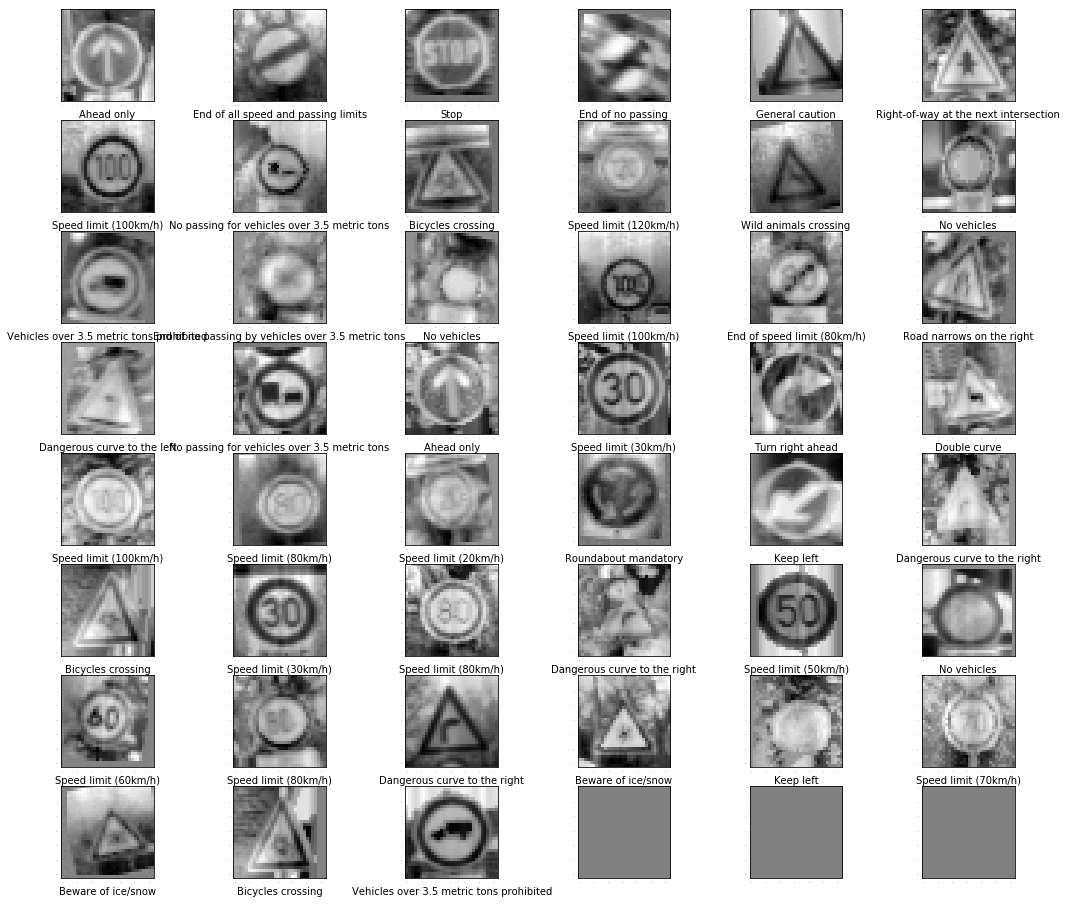

In [15]:
rand_images, rand_labels, random_indexes = draw_random_images(X_train,Y_train,45)         
graph_images(rand_images,rand_labels)

# Model

Topology of the network for a input image as a `32x32x1` tensor:

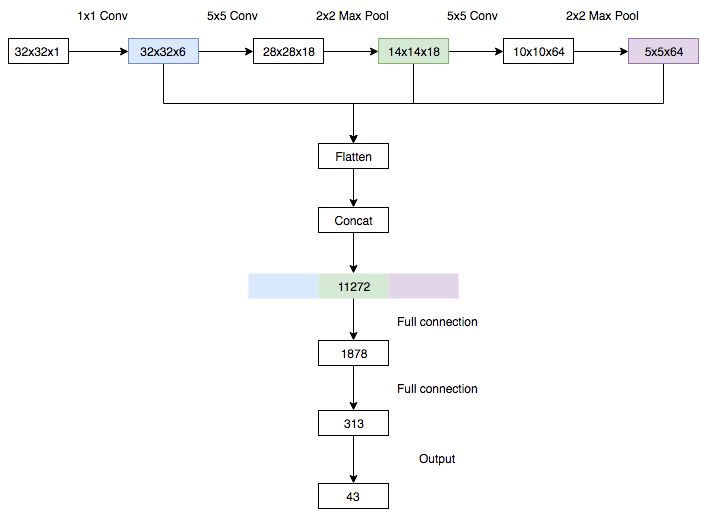

## Code

The rough idea is that we exchange width for depth. Deeper network means higher level representations and more parameters. Past this rough intuitive understanding, it is mainly trial and errors an performance trade-offs. Too many parameters and we are at risk of memory exhaustion, overfitting and long training times. Too little and we risk to underfit the problem. The dropout layer consumes parameters that would overfit for redundancies and better robustness. 

In [16]:
model_parameters = {
    'image_depth': 1,
    'mu': 0,
    'sigma': 0.1,
    'conv0_depth': 6,
    'conv1_depth': 18,
    'conv2_depth': 64,
    'fc1_depth': 1878,
    'fc2_depth': 313,
    'keep_prob': 1.,
    'n_classes': len(set(Y_test))
}

def model(x,keep_prob):    

    mu = model_parameters['mu']
    sigma = model_parameters['sigma']
    img_depth = model_parameters['image_depth']
    n_classes = model_parameters['n_classes']
    tf_activations = {}
    
    # Convolutional : 32 x 32 x 1 → 32 x 32 x conv0_depth 
    conv0_depth = model_parameters['conv0_depth']
    conv_1x1_W = tf.Variable(tf.truncated_normal(shape=(1, 1, 1, conv0_depth), mean = mu, stddev = sigma))
    conv_1x1_b = tf.Variable(tf.zeros(conv0_depth))
    conv_1x1   = tf.nn.conv2d(x, conv_1x1_W, strides=[1, 1, 1, 1], padding='VALID') + conv_1x1_b        
    
    # Convolutional : 32 x 32 x conv0_depth → 28 x 28 x conv1_depth 
    conv1_depth = model_parameters['conv1_depth']
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv0_depth, conv1_depth), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(conv1_depth))
    conv1   = tf.nn.conv2d(conv_1x1, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    
    # Relu
    conv1 = tf.nn.relu(conv1)

    # Pooling : 28 x 28 x conv1_depth → 14 x 14 x conv1_depth
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    tf_activations['conv1'] = conv1
    

    # Convolutional : 14 x 14 x conv1_depth → 10 x 10 x conv2_depth
    conv2_depth = model_parameters['conv2_depth']
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, conv1_depth, conv2_depth), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(conv2_depth))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Relu
    conv2 = tf.nn.relu(conv2)

    # Pooling : 10 x 10 x conv2_depth → 5 x 5 x conv2_depth
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    tf_activations['conv2'] = conv2
    
    # Flatten conv2 and conv1 then concat into fc0 ≡ conv1,conv2
    fc00 = flatten(conv_1x1)
    fc01 = flatten(conv1)
    fc02 = flatten(conv2)
    fc0  = tf.concat(1,[fc00,fc01, fc02])
    
    # Fully Connected : len(fc0) → fc1_depth
    fc1_depth = model_parameters['fc1_depth']
    fc1_W = tf.Variable(tf.truncated_normal(shape=(32*32*conv0_depth + 14*14*conv1_depth + 5*5*conv2_depth, fc1_depth), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(fc1_depth))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Relu
    fc1    = tf.nn.relu(fc1)

    # Fully Connected : fc1_depth → fc2_depth
    fc2_depth = model_parameters['fc2_depth']
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(fc1_depth, fc2_depth), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(fc2_depth))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Relu
    fc2    = tf.nn.relu(fc2)
    
    # Dropout
    fc2    = tf.nn.dropout(fc2,keep_prob) 

    # Fully Connected : fc2_depth → n_classes
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(fc2_depth, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, tf_activations

## Construction

We first started with [LetNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) and data re-splitted across training, validation and test into 70%, 20% and 10% of whole data respectively. The 93.8% accuracy on the test set gave us reasons to continue to invest time into improving its performance.

Grayscaling the images led to a 1.2% improvement up to 95.0% accuracy on the test set.

Centering the pixels values around 0 lead to a 1.3% improvement up to 96.3% accuracy on the test set.

Making the distribution of training images even across classes lead to a 1.3% improvement up to 97.3% accuracy on the test set.

We flattened and concatenated the outputs of the all convolutional layers into the first fully connected layer as done in [sermanet-ijcnn-11](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), augmented the number of epochs and divided the learning rate by augmenting the size of the batches up to 512 for a 0.8% increase up to 98.4% accuracy on the test set.

We added the a dropout layer in between the fully connected layers of a 0.3% accuracy increase up to 98.7% accuracy on the test set.

We added a 1x1 convolutional layer at the beginning of the network and increased the depth of all layers, increased the batch size up to 1024 to have a lower learning rate and augmented the number of epochs to 30 for a 0.3% accuracy increase up to 99.0% accuracy on the test set.

# Training

[Practical Recommendations for Gradient-Based Training of Deep Architectures](https://arxiv.org/pdf/1206.5533.pdf) gives this formula that helps understanding how `batch_size` and `learning_rate` are related:

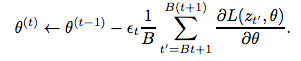

The bigger the batch (**B**), the lower the resulting `learning_rate`. A bigger batch also means a bigger region of the cost function that is optimized at each batch. For this reason, we prefered to increase the `batch_size` as long as the time/space performance where acceptable during the trial and error phase. The smaller the learning rate, the higher the number of epochs to compensate the smaller steps and avoiding getting stuck into a local minimum. Too many epochs and we are at risk of overfitting: the network learns the data set instead of how to generalize it. We just don't train past a certain amount of epochs when we see that the accuracy does not improve anymore.

[Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980) makes a great case for using the `AdamOptimizer` instead of others.

> 6.3 EXPERIMENT: CONVOLUTIONAL NEURAL NETWORKS
>
> We show the effectiveness of Adam in deep CNNs. Our CNN architecture has three
> alternating stages of 5x5 convolution filters and 3x3 max pooling with stride of
> 2 that are followed by a fully connected layer of 1000 rectified linear hidden
> units (ReLU’s).  The input image are pre-processed by whitening, and dropout
> noise is applied to the input layer and fully connected layer.
> 
> Interestingly, although both Adam and Adagrad make rapid progress lowering the
> cost in the initial stage of the training, shown in Figure 3 (left), Adam and
> SGD eventually converge considerably faster than Adagrad for CNNs shown in
> Figure 3 (right).


## Code

In [17]:
training_parameters = {
    'epochs': 30,
    'batch_size': 1024,
    'rate': 0.0005,
    'save_file': "./saved_parameters/lenet-5",
    'keep_prob': 0.75
}

def train(X_train, model, Y_train,X_valid, Y_valid):
    tf.reset_default_graph()
    
    image_width, image_height, *rest = X_train[0].shape
    n_classes = len(set(Y_train))
    x = tf.placeholder(tf.float32,(None,image_width,image_height,model_parameters['image_depth']))
    keep_prob = tf.placeholder(tf.float32)
    logits, tf_activations = model(x,keep_prob)
    y = tf.placeholder(tf.int32,(None))
    one_hot_y = tf.one_hot(y, n_classes)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = training_parameters['rate'])
    training_operation = optimizer.minimize(loss_operation)
    
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    def evaluate(X_data, y_data):
        batch_size = training_parameters['batch_size']
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, training_parameters['batch_size']):
            batch_x, batch_y = X_data[offset:offset+batch_size], y_data[offset:offset+batch_size]
            accuracy = sess.run(accuracy_operation, 
                                feed_dict={x: batch_x, y: batch_y, keep_prob: 1.})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    saver = tf.train.Saver()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        
        epochs_accuracies = []
        for i in range(training_parameters['epochs']):
            X_train, Y_train = shuffle(X_train, Y_train)
            for offset in range(0, num_examples, training_parameters['batch_size']):
                end = offset + training_parameters['batch_size']
                batch_x, batch_y = X_train[offset:end], Y_train[offset:end]
                sess.run(training_operation, 
                         feed_dict={x: batch_x, y: batch_y, keep_prob: training_parameters['keep_prob']})

            epoch_idx = i+1
            validation_accuracy = evaluate(X_valid, Y_valid)
            epochs_accuracies.append((epoch_idx,validation_accuracy))
            print("EPOCH {} ...".format(epoch_idx))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        plot_barchart_of_distribution(epochs_accuracies,
                                     title="Epoch -> Validation Accuracy",
                                     x_label="Epochs",
                                     y_label="Validation Accuracies")
        saver.save(sess, training_parameters["save_file"])
        print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.887

EPOCH 2 ...
Validation Accuracy = 0.945

EPOCH 3 ...
Validation Accuracy = 0.962

EPOCH 4 ...
Validation Accuracy = 0.975

EPOCH 5 ...
Validation Accuracy = 0.978

EPOCH 6 ...
Validation Accuracy = 0.981

EPOCH 7 ...
Validation Accuracy = 0.983

EPOCH 8 ...
Validation Accuracy = 0.985

EPOCH 9 ...
Validation Accuracy = 0.985

EPOCH 10 ...
Validation Accuracy = 0.984

EPOCH 11 ...
Validation Accuracy = 0.988

EPOCH 12 ...
Validation Accuracy = 0.987

EPOCH 13 ...
Validation Accuracy = 0.988

EPOCH 14 ...
Validation Accuracy = 0.988

EPOCH 15 ...
Validation Accuracy = 0.987

EPOCH 16 ...
Validation Accuracy = 0.987

EPOCH 17 ...
Validation Accuracy = 0.987

EPOCH 18 ...
Validation Accuracy = 0.987

EPOCH 19 ...
Validation Accuracy = 0.987

EPOCH 20 ...
Validation Accuracy = 0.990

EPOCH 21 ...
Validation Accuracy = 0.989

EPOCH 22 ...
Validation Accuracy = 0.988

EPOCH 23 ...
Validation Accuracy = 0.987

EPOCH 24 ...
Validation Accura

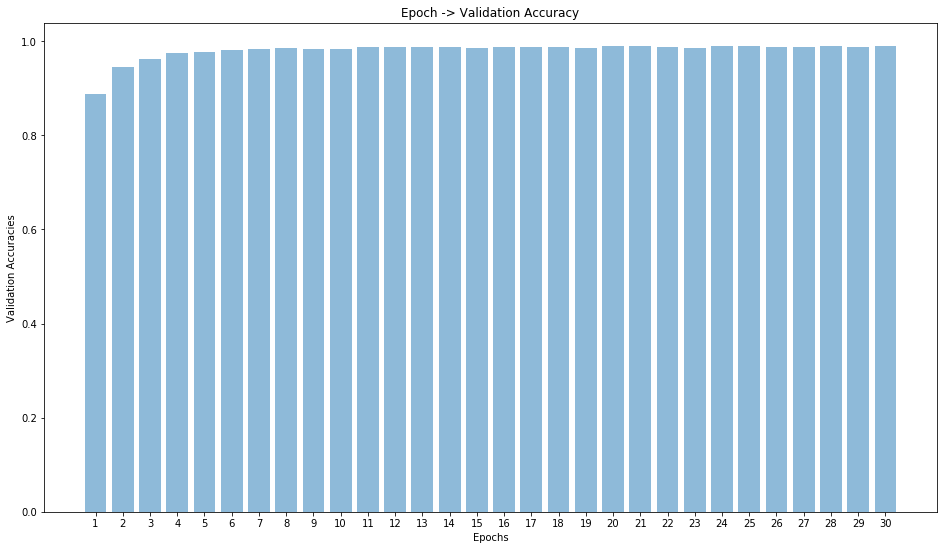

Model saved


In [18]:
train(X_train,model,Y_train,X_valid, Y_valid)

# Performance

`results` is `[(predicted_class,expected_class), ...]`:

In [19]:
results = collect_results(training_parameters, X_test,model,Y_test)
print(results[0:5])

[[ 3  3]
 [25 25]
 [28 28]
 [38 38]
 [31 31]]


From the list of predictions and expectations, `to_true_false_positive_negative` returns a matrix where each row represents a class and contains its numbers of True Positives, True Negatives, False Positives, False Negatives.

In [20]:
true_false_positive_negative = to_true_false_positive_negative(results)

From the number of true/false positives/negatives, `to_accuracy_precision_recall` returns a matrix where each row matches a class and contains Accuracy,Precision and Recall for that class.

In [21]:
accuracy_precision_recall = to_accuracy_precision_recall(true_false_positive_negative)

Plot accuracy, precision and recall per class on the test set. These measures help the understanding of the model performances, where it is good or bad:

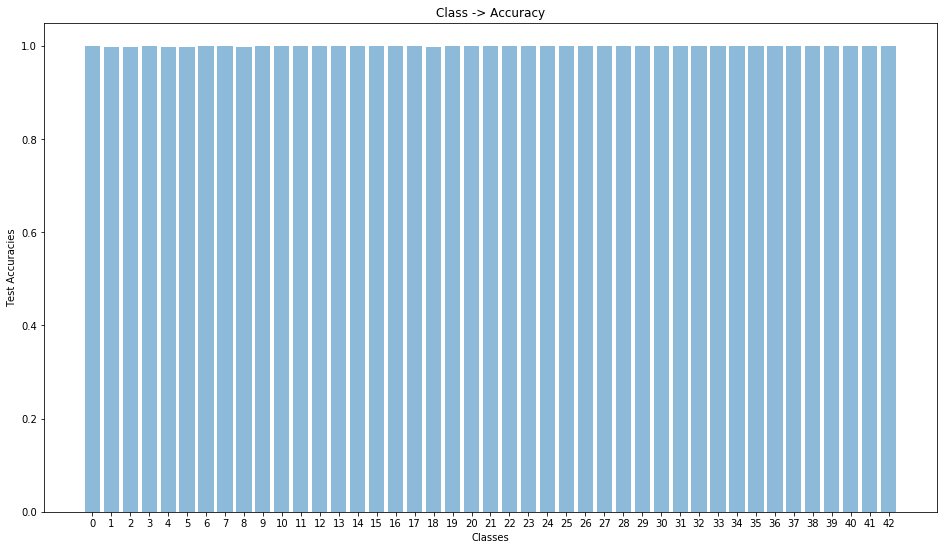

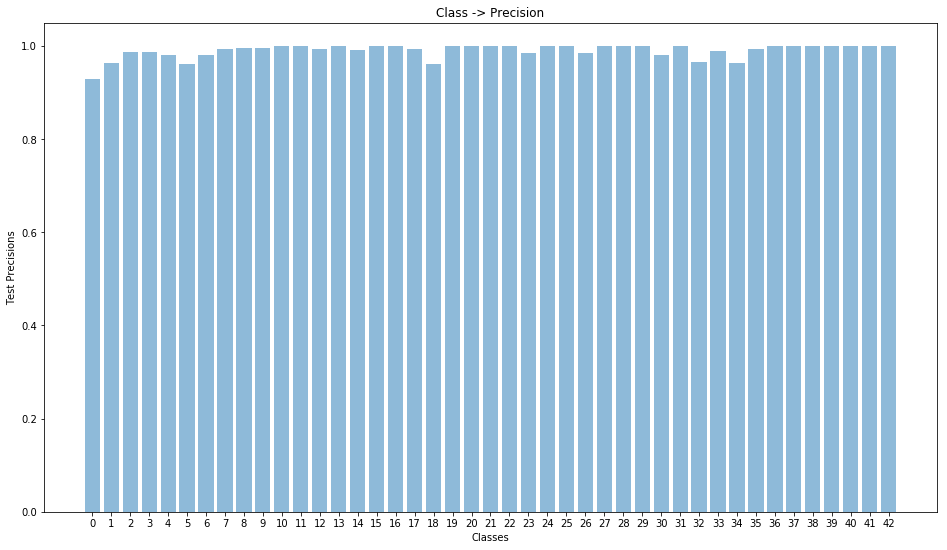

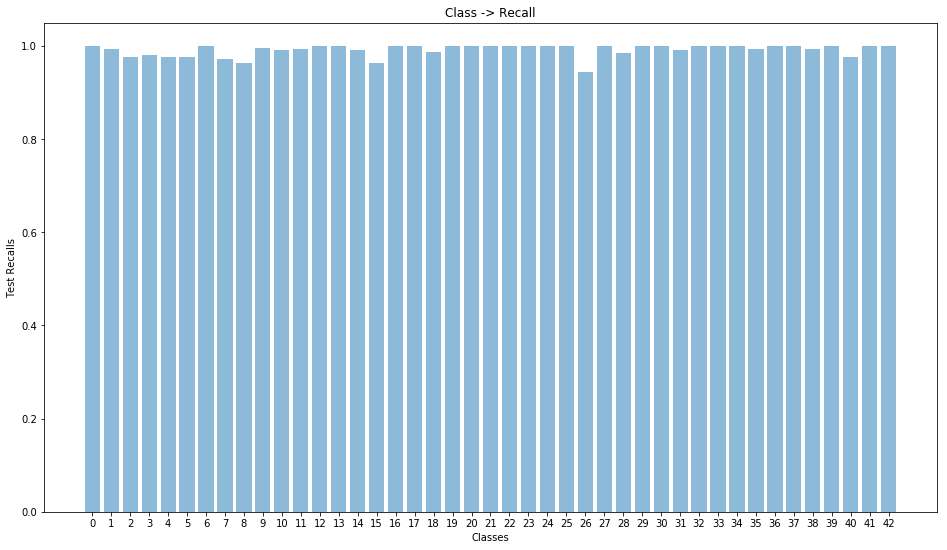

In [22]:
per_class_accuracy = [(idx,accuracy) 
                      for (idx,(accuracy,precision,recall)) in enumerate(accuracy_precision_recall)]

per_class_precision = [(idx,precision) 
                      for (idx,(accuracy,precision,recall)) in enumerate(accuracy_precision_recall)]

per_class_recall = [(idx,recall) 
                      for (idx,(accuracy,precision,recall)) in enumerate(accuracy_precision_recall)]

plot_barchart_of_distribution(per_class_accuracy,
                                     title="Class -> Accuracy",
                                     x_label="Classes",
                                     y_label="Test Accuracies")
plot_barchart_of_distribution(per_class_precision,
                                     title="Class -> Precision",
                                     x_label="Classes",
                                     y_label="Test Precisions")
plot_barchart_of_distribution(per_class_recall,
                                     title="Class -> Recall",
                                     x_label="Classes",
                                     y_label="Test Recalls")

From the list of predictions and expectations, `model_accuracy` returns the accuracy of the model.

In [23]:
print("Model accuracy: {:.1%}".format(model_accuracy(results)))

Model accuracy: 98.9%


---

## Test The Model On New Images

### Load and Output the Images

Load some images we found on the net to test the model on signs we have never seen:

Image data shape = (32, 32, 3)
Number of training examples = 6
Number of classes = 6


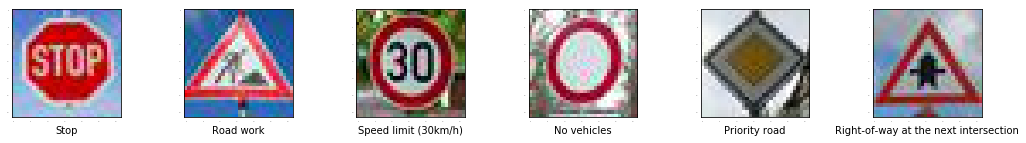

In [24]:
X_web_test, Y_web_test = get_and_split_web_traffic_signs()

print("Image data shape =", X_web_test[0].shape)
print("Number of training examples =", len(X_web_test))
print("Number of classes =", len(set(Y_web_test)))

graph_images(X_web_test, Y_web_test)

To apply the model we need to preprocess them:

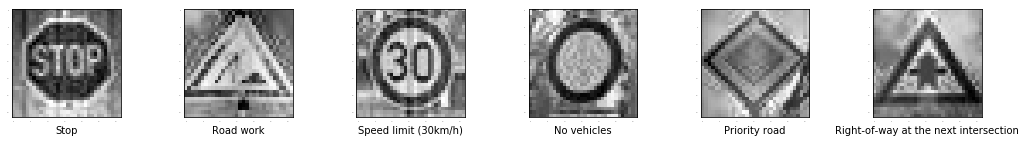

In [25]:
X_web_test,Y_web_test = preprocess_images(X_web_test,Y_web_test)

graph_images(X_web_test,Y_web_test)

### Predict the Sign Type for Each Image

`predict` returns predicted labels and associated probabilities of the trained model for each image it considers:

In [26]:
Y_web_test_predicted, probabilities = predict(model_parameters,training_parameters,model,X_web_test)

For each image, we graph the certainty of the network considering its predicted label:

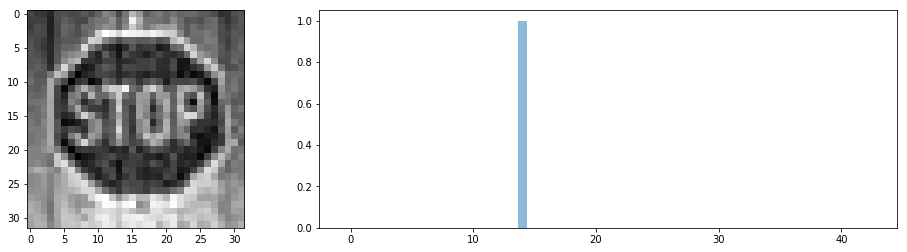

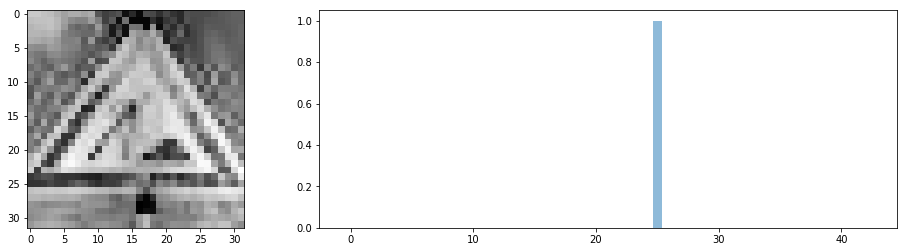

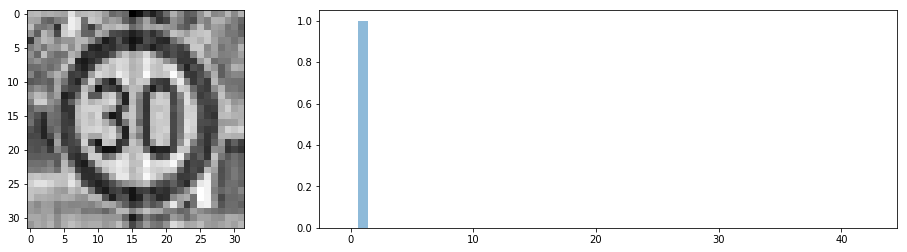

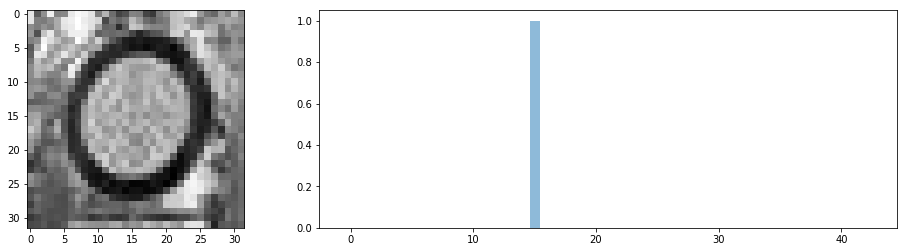

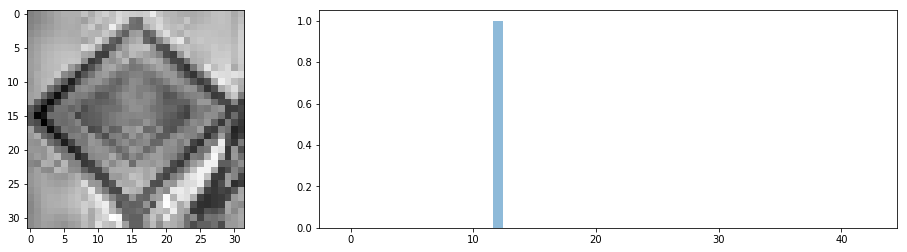

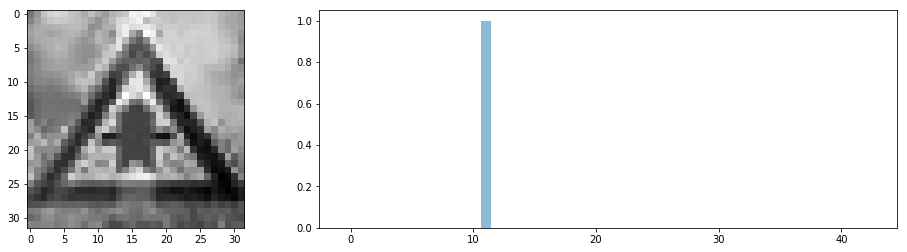

XXXXXXXXXXXXXXXXXXX
X Accurracy: 100.0%
XXXXXXXXXXXXXXXXXXX


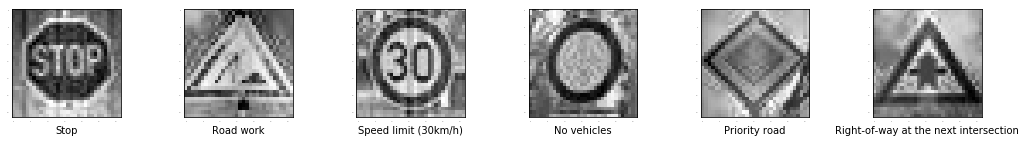

In [27]:
for (image,image_probabilities) in zip(X_web_test,probabilities):
    graph_image_prob(image,image_probabilities)

graph_images(X_web_test, Y_web_test_predicted)
accuracy(Y_web_test, Y_web_test_predicted)

There was no real difficulty a priori for the network to classify these signs: no extreme contrast, overlapping environment, bad centring, damaged signs, bad weather, etc. Perfect signs and perfect classification! Compared to the test set, these good results were expected.

Nevertheless, 1% of innacuracy on the test set is way to high. It's lower than humans which sits at 98.81% accuracy according to [sermanet-ijcnn-11](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) but humans can second guess a traffic sign when a model cannot (it's a function). Humans have a great number of redundancies that lead to ignore traffic signs for more important signals: the local performance is not an indication for a global one!

That said, it's an encouraging step forward!

---

## Neural Network's State

As NVIDIA's did in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State, let's show the internal state of our model. Given the following input image: 

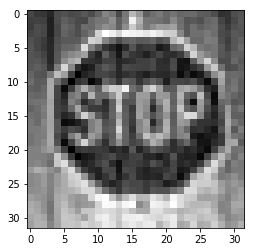

In [28]:
stimuli_image = X_web_test[0]
plt.imshow(np.squeeze(stimuli_image))
plt.show()

Let's check what the network is looking for:

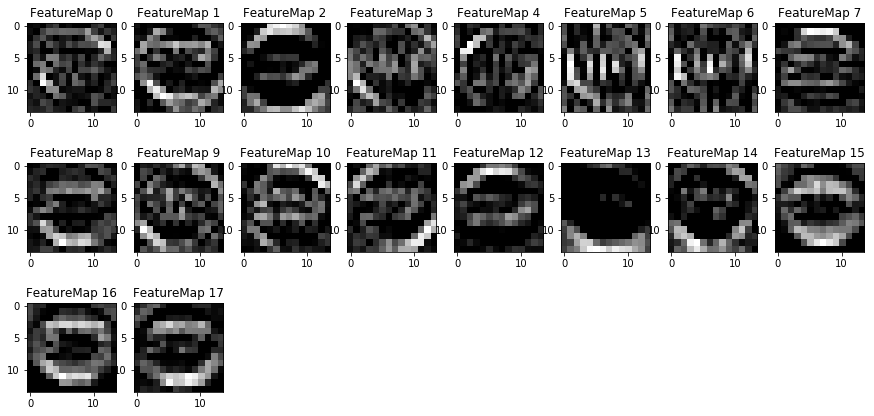

In [29]:
show_hidden_layers(model_parameters,training_parameters, np.array([stimuli_image]), model)

Amazing! The network learned on its own features that matter: we can distinctively see features of the signs in the hidden layers. That said, given this map of features, how this information can be used to update the model for improved performance? E.g. `FeatureMap1` and `FeatureMap5` are almost the same. Is that redundancy an assest because it gives more robustness to the model or is it a liability in the sense that the model could do equally good without this redundancy?